In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import models, datasets
import torchvision.transforms as transforms
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split
import torchvision.models as models

# Hyperparameters
N_EPOCHS = 15
LEARNING_RATE = 0.0001
TEST_SIZE=0.20
BATCH_SIZE=128

# Transformations for our dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert PIL image to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1] for better training stability
])

# Load the dataset
root_dir = 'data_zadanie2/'  # Modify this to the path where your image folders (cat, chicken, etc.) are located
full_dataset = datasets.ImageFolder(root=root_dir, transform=transform)

# Splitting the dataset
train_size = int((1 - TEST_SIZE) * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [2]:
# Load the pre-trained AlexNet model
def get_alex_model():
    alexnet = models.alexnet(pretrained=True)
    num_layers = 0

    for param in alexnet.parameters():
        param.requires_grad = False
        num_layers = num_layers + 1

    alexnet.classifier[6] = nn.Linear(4096, 8)  
    alexnet.eval()
    input_tensor = torch.randn(1, 3, 224, 224)  # Example random input
    alexnet(input_tensor)
    num_layers

    return alexnet

def get_vgg16_model():
    vgg16 = models.vgg16(pretrained=True)
    num_layers = 0

    for param in vgg16.features.parameters():
        param.requires_grad = False
        num_layers = num_layers + 1

    num_features = vgg16.classifier[6].in_features
    vgg16.classifier[6] = nn.Linear(num_features, 8)  # Modify the output layer for your specific task
    vgg16.eval()
    input_tensor = torch.randn(1, 3, 224, 224)  # Example random input
    vgg16(input_tensor)
    
    return vgg16

def get_resnet18_model():
    resnet18 = models.resnet18(pretrained=True)
    num_layers = 0

    for param in resnet18.parameters():
        param.requires_grad = False
        num_layers = num_layers + 1

    num_features = resnet18.fc.in_features
    resnet18.fc = nn.Linear(num_features, 8)  # Modify the output layer for your specific task
    resnet18.eval()
    input_tensor = torch.randn(1, 3, 224, 224)  # Example random input
    resnet18(input_tensor)
    
    return resnet18


def get_mobilenet_model():
    mobilenet = models.mobilenet_v2(pretrained=True)
    num_layers = 0

    for param in mobilenet.parameters():
        param.requires_grad = False
        num_layers = num_layers + 1

    num_features = mobilenet.classifier[1].in_features
    mobilenet.classifier[1] = nn.Linear(num_features, 8)  # Modify the output layer for your specific task
    mobilenet.eval()
    input_tensor = torch.randn(1, 3, 224, 224)  # Example random input
    mobilenet(input_tensor)
    
    return mobilenet

step = 16/4
step = 26/4
step = 62/4
step = 158/4

In [3]:
# define the loss functions and optimizers
# get_mobilenet_model()

In [4]:
def evaluate_model(model, dataloader):
    """
    Evaluate the given model using the specified dataloader.

    Args:
    - model: Trained PyTorch model
    - dataloader: DataLoader for the evaluation data

    Returns:
    - Accuracy of the model on the evaluation data
    """
    correct = 0
    total = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in tqdm(test_loader, desc="Evaluation", leave=False):
            inputs, labels = inputs.to(device).float(), labels.to(device)  # Move inputs and labels to the device and ensure float32 type
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [5]:
# Training
def train_model(model, optimizer, criterion, dataloader, epochs, unfreez, save_name):
    """
    Train a given model using the specified optimizer and criterion.

    Args:
    - model: PyTorch model to be trained
    - optimizer: Optimizer for updating model parameters
    - criterion: Loss function
    - dataloader: DataLoader for the training data
    - epochs: Number of epochs (default=10)

    Returns:
    - list of losses per epoch
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()  # Set the model to training mode
    loss_list = []  # To store the loss per epoch
    accuracy_list= []
    freeze_first_n_layers = 0 
    
    # Loop over epochs
    for epoch in trange(epochs, desc="Epochs"):
        # ... [rest of the code remains unchanged]
        epoch_loss = 0  # Initialize epoch loss
        model.zero_grad()
        count = 0

        if epoch < 3:
            freeze_first_n_layers = freeze_first_n_layers - step
        elif epoch < 6:
            freeze_first_n_layers = freeze_first_n_layers - 2*step
        elif epoch < 9:
            freeze_first_n_layers = freeze_first_n_layers - 3*step
        elif epoch < 12:
           freeze_first_n_layers = freeze_first_n_layers - 4*step

        if unfreez:
            # unfreeze backbone layers
            for param in model.children():
                count +=1
                if count > freeze_first_n_layers: 
                    param.requires_grad = True     

        for inputs, labels in tqdm(train_loader, desc="Batches", leave=False):
            inputs, labels = inputs.to(device).float(), labels.to(device)
            optimizer.zero_grad()  # Clear gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            epoch_loss += loss.item()
        accuracy=evaluate_model(model, DataLoader(test_dataset, batch_size=BATCH_SIZE))
        accuracy_list.append(accuracy)
        avg_loss = epoch_loss / len(dataloader)
        loss_list.append(avg_loss)
        print("Epoch {}, Loss {:.6f}, Accuracy {:.2f}% ".format(epoch, avg_loss, accuracy))

    torch.save(model.state_dict(), 'modely_zadanie_2/' + save_name + ".pth")   
    model.eval()
    return loss_list,accuracy_list

In [6]:
if torch.cuda.is_available():
    print("cuda")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()

# Training the CNN model
cnn_model1 = get_mobilenet_model()
cnn_optimizer = torch.optim.Adam(cnn_model1.parameters(), lr=LEARNING_RATE)
cnn_model1.to(device)
cnn_losses1,cnn_accuracy_list1 = train_model(cnn_model1, cnn_optimizer, criterion, DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True), epochs=N_EPOCHS, unfreez=True, save_name='mobilenet_model_1')
# Evaluating the CNN model
cnn_accuracy = evaluate_model(cnn_model1, DataLoader(test_dataset, batch_size=BATCH_SIZE))
print(f"CNN Model Accuracy: {cnn_accuracy:.2f}%")

cnn_model2 = get_mobilenet_model()
cnn_optimizer = torch.optim.Adam(cnn_model2.parameters(), lr=LEARNING_RATE)
cnn_model2.to(device)
cnn_losses2,cnn_accuracy_list2 = train_model(cnn_model2, cnn_optimizer, criterion, DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True), epochs=N_EPOCHS, unfreez=False,save_name='mobilenet_model_2')
# Evaluating the CNN model
cnn_accuracy = evaluate_model(cnn_model2, DataLoader(test_dataset, batch_size=BATCH_SIZE))
print(f"CNN Model Accuracy: {cnn_accuracy:.2f}%")

# Augmentation
# Define a custom dataset class for rotated images
import random
class RotatedImageDataset(Dataset):
    def __init__(self, original_dataset, rotate_prob=1):
        self.original_dataset = original_dataset
        self.rotate_prob = rotate_prob

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        image, label = self.original_dataset[idx]

        # Randomly decide whether to rotate the image or not
        should_rotate = random.random() < self.rotate_prob

        if should_rotate:
            # Rotate the image by 90 degrees
            image = transforms.functional.rotate(image, 90)

        return image, label

# Hyperparameters
TEST_SIZE=0.40

# Transformations for our dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),          
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1] for better training stability
])

# Load the dataset
root_dir = 'data_zadanie2/'  # Modify this to the path where your image folders (cat, chicken, etc.) are located
original_dataset = datasets.ImageFolder(root=root_dir, transform=transform)

augment_data_size = int((1 - 0.6) * len(original_dataset))
unused_size = len(original_dataset) - augment_data_size
augment_data, unused = random_split(original_dataset, [augment_data_size, unused_size])
rotated_dataset = RotatedImageDataset(augment_data, rotate_prob=1)

train_size = int((1 - TEST_SIZE) * len(original_dataset))
test_size = len(original_dataset) - train_size
train_dataset, test_dataset = random_split(original_dataset, [train_size, test_size])
train_dataset = torch.utils.data.ConcatDataset([train_dataset, rotated_dataset])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

cnn_model3 = get_mobilenet_model()
cnn_optimizer = torch.optim.Adam(cnn_model3.parameters(), lr=LEARNING_RATE)
cnn_model3.to(device)
cnn_losses3,cnn_accuracy_list3 = train_model(cnn_model3, cnn_optimizer, criterion, DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True), epochs=N_EPOCHS, unfreez=True,save_name='mobilenet_model_3')
# Evaluating the CNN model
cnn_accuracy = evaluate_model(cnn_model3, DataLoader(test_dataset, batch_size=BATCH_SIZE))
print(f"CNN Model Accuracy: {cnn_accuracy:.2f}%")




cuda


/home/matus/myvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/matus/myvenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 0, Loss 1.483766, Accuracy 81.66% 


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 1, Loss 0.756580, Accuracy 91.09% 


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 2, Loss 0.511324, Accuracy 92.78% 


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 3, Loss 0.400868, Accuracy 93.87% 


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 4, Loss 0.340212, Accuracy 94.10% 


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 5, Loss 0.300510, Accuracy 94.47% 


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 6, Loss 0.271713, Accuracy 94.49% 


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 7, Loss 0.251525, Accuracy 94.73% 


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 8, Loss 0.236154, Accuracy 95.04% 


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 9, Loss 0.223252, Accuracy 94.75% 


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 10, Loss 0.211980, Accuracy 95.04% 


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 11, Loss 0.204874, Accuracy 95.06% 


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 12, Loss 0.196153, Accuracy 95.09% 


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 13, Loss 0.188773, Accuracy 95.30% 


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 14, Loss 0.182963, Accuracy 95.22% 


Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

CNN Model Accuracy: 95.22%


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 0, Loss 1.458536, Accuracy 83.92% 


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 1, Loss 0.744950, Accuracy 90.78% 


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 2, Loss 0.505868, Accuracy 92.13% 


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 3, Loss 0.397520, Accuracy 92.99% 


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 4, Loss 0.337927, Accuracy 93.97% 


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 5, Loss 0.298895, Accuracy 94.03% 


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 6, Loss 0.271132, Accuracy 94.39% 


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 7, Loss 0.250653, Accuracy 94.60% 


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 8, Loss 0.235956, Accuracy 94.73% 


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 9, Loss 0.223243, Accuracy 94.68% 


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 10, Loss 0.211832, Accuracy 94.75% 


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 11, Loss 0.203232, Accuracy 94.75% 


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 12, Loss 0.195736, Accuracy 94.88% 


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 13, Loss 0.188850, Accuracy 94.96% 


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 14, Loss 0.182904, Accuracy 95.19% 


Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

CNN Model Accuracy: 95.19%


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Batches:   0%|          | 0/151 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 0, Loss 1.457630, Accuracy 85.10% 


Batches:   0%|          | 0/151 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 1, Loss 0.817308, Accuracy 91.39% 


Batches:   0%|          | 0/151 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 2, Loss 0.601119, Accuracy 92.53% 


Batches:   0%|          | 0/151 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 3, Loss 0.499014, Accuracy 92.91% 


Batches:   0%|          | 0/151 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 4, Loss 0.439956, Accuracy 93.45% 


Batches:   0%|          | 0/151 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 5, Loss 0.401034, Accuracy 93.61% 


Batches:   0%|          | 0/151 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 6, Loss 0.372838, Accuracy 93.77% 


Batches:   0%|          | 0/151 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 7, Loss 0.352518, Accuracy 93.86% 


Batches:   0%|          | 0/151 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 8, Loss 0.334602, Accuracy 94.10% 


Batches:   0%|          | 0/151 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 9, Loss 0.321688, Accuracy 94.13% 


Batches:   0%|          | 0/151 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 10, Loss 0.310113, Accuracy 94.19% 


Batches:   0%|          | 0/151 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 11, Loss 0.299980, Accuracy 94.31% 


Batches:   0%|          | 0/151 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 12, Loss 0.291672, Accuracy 94.31% 


Batches:   0%|          | 0/151 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 13, Loss 0.283917, Accuracy 94.35% 


Batches:   0%|          | 0/151 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 14, Loss 0.277501, Accuracy 94.41% 


Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

CNN Model Accuracy: 94.41%


In [7]:
import pickle

# # Save the lists to a file
# with open('cnn_losses1.pkl', 'wb') as f:
#     pickle.dump(cnn_losses1, f)

# with open('cnn_accuracy_list1.pkl', 'wb') as f:
#     pickle.dump(cnn_accuracy_list1, f)

# with open('cnn_losses1.pkl', 'rb') as f:
#     cnn_losses1 = pickle.load(f)

# with open('cnn_accuracy_list1.pkl', 'rb') as f:
#     cnn_accuracy_list1 = pickle.load(f)

In [8]:
import matplotlib.pyplot as plt

def plot_accuracy(accuracy_list1,accuracy_list2,accuracy_list3, model_name):

    plt.figure(figsize=(12, 6))
    plt.plot(accuracy_list1, '-o', label=f'{model_name} Accuracy - Attempt 1')
    plt.plot(accuracy_list2, '-o', label=f'{model_name} Accuracy - Attempt 2')
    plt.plot(accuracy_list3, '-o', label=f'{model_name} Accuracy - Attempt 3')
    plt.title(f'Accuracy Evolution for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()



In [9]:
import matplotlib.pyplot as plt

def plot_losses(cnn_losses1,cnn_losses2,cnn_losses3, model_name):

    plt.figure(figsize=(12, 6))
    plt.plot(cnn_losses1, '-o', label=f'{model_name} Losses  Attempt 1')
    plt.plot(cnn_losses2, '-o', label=f'{model_name} Losses  Attempt 2')
    plt.plot(cnn_losses3, '-o', label=f'{model_name} Losses  Attempt 3')
    plt.title(f'Training Loss evolution for {model_name}')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()



In [10]:
def plot_filters(layer, layer_idx=0):
    # Extract filter weights from the layer and convert to numpy for visualization.
    filters = layer[layer_idx].weight.data.cpu().numpy()
    
    # Initialize a figure for displaying multiple images.
    fig = plt.figure(figsize=(10, 5))
    
    # Loop through each filter in the layer.
    for i in range(filters.shape[0]):
        ax = fig.add_subplot(2, filters.shape[0]//2, i+1) # arranging subplots in 2 rows.
        
        # Display the filter as an image.
        ax.imshow(filters[i][0], cmap='gray')
        
        # Don't show axis for clarity.
        ax.axis('off')
    
    # Show all the filter images.
    plt.show()



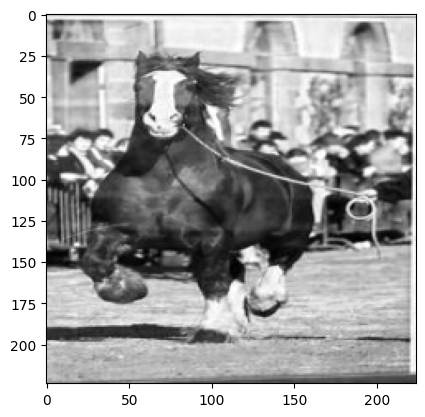

In [11]:
def visualize_feature_maps(model, input_image):
    # Making sure model is in eval mode
    model.eval()
    
    # Running the image through the first conv layer
    feature_maps1 = model.conv1(input_image.unsqueeze(0).float().to(device))
    # If you want to visualize after the second conv layer
    # feature_maps2 = model.conv2(F.relu(feature_maps1))
    
    n_feature_maps = feature_maps1.shape[1]
    
    # Plotting each feature map
    for i in range(n_feature_maps):
        plt.subplot(8, 8, i+1)  # Assuming a max of 64 feature maps for display
        plt.imshow(feature_maps1[0][i].cpu().detach().numpy(), cmap='gray')
        plt.axis('off')
    plt.show()

# Select a random image from the dataset
image, _ = test_dataset[5]
plt.imshow(image[0], cmap='gray')  # Displaying the selected image
plt.show()

# Displaying feature maps for the selected image
# visualize_feature_maps(cnn_model, image)

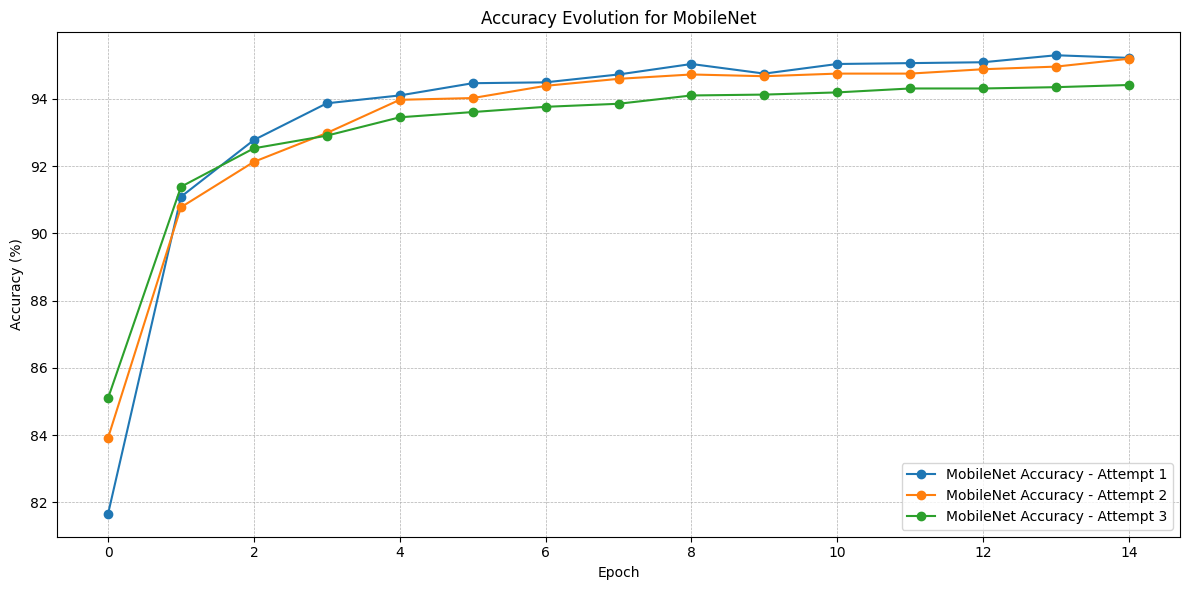

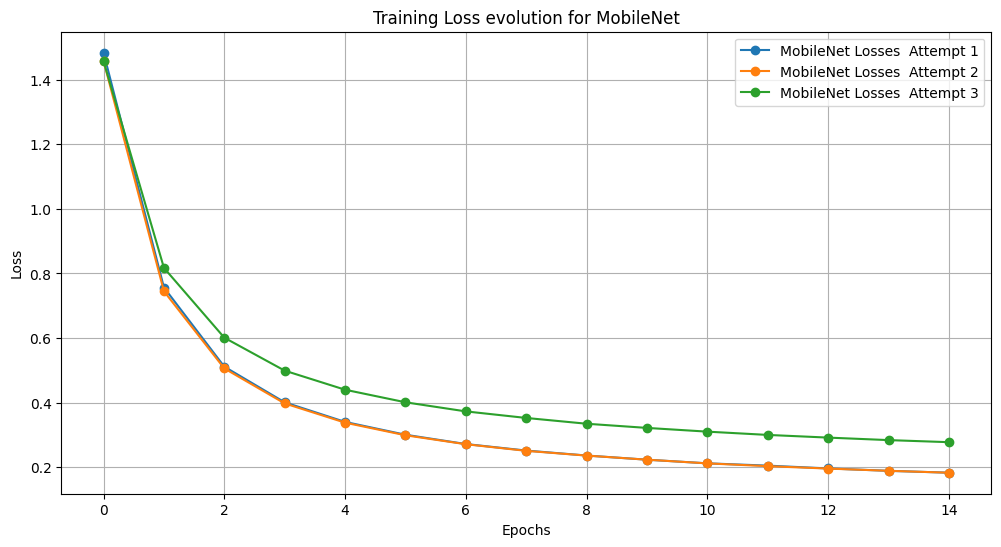

In [12]:
plot_accuracy(cnn_accuracy_list1, cnn_accuracy_list2, cnn_accuracy_list3, "MobileNet")
plot_losses(cnn_losses1, cnn_losses2, cnn_losses3, "MobileNet")

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def get_all_preds_and_labels(model, dataloader):
    # Empty tensors to store all predictions and true labels.
    all_preds = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)
    
    # Loop through the data in the dataloader.
    for inputs, labels in dataloader:
        # Convert inputs to float32
        inputs = inputs.float()
        # Move the data to the device (GPU/CPU).
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass to get predictions.
        outputs = model(inputs)
        
        # Get the index (class label) with the maximum score as the prediction.
        _, preds = torch.max(outputs, 1)
        
        # Append the batch's predictions and labels to the accumulating tensors.
        all_preds = torch.cat((all_preds, preds), dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)
    
    # Return all predictions and true labels.
    return all_preds, all_labels

import numpy as np
from sklearn import metrics

def plot_confusion_matrix(all_preds, all_labels):
    # Compute the confusion matrix using sklearn's function.
    cm = metrics.confusion_matrix(all_labels.cpu(), all_preds.cpu())
    
    # Define the labels you're using (in this case, it's A-J).
    labels = ["cat","chicken","cow","dog","elephant","horse","sheep","squirrel"]
    
    # Create the ConfusionMatrixDisplay object.
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    # Plot the confusion matrix.
    cm_display.plot(cmap='Blues')
    plt.show()

# After training your CNN model
cnn_model = cnn_model.float()
all_preds, all_labels = get_all_preds_and_labels(cnn_model, DataLoader(test_dataset, batch_size=64))
plot_confusion_matrix(all_preds, all_labels)


NameError: name 'cnn_model' is not defined